In [1]:
'''
주제 : 식당 상권 데이터와 머신러닝 기법을 이용한 식당 수요 예측 모델
제출자 : 강영웅(성균관대학교 글로벌 경제학과 3학년 재학)
이용 데이터 : 망고플레이트-관광지 인기 식당.csv

이하 작성된 코드는 망고플레이트가 제공한 관광지 인기식당 데이터에서 의미있는 데이터를 추출하여 이를 바탕으로 식당의 수요를 예측한 모델입니다.
여기서 설명변수로 사용한 데이터에는 식당의 위치(위도와 경도), 리뷰평점, 리뷰수, 조회수를 비롯한 수치 데이터와 
판매음식, 주차가능여부, 1인당 음식 가격 등 문자열 데이터도 포함하였습니다.

타깃(Target)이 되는 종속변수 데이터로는 식당에 대한 사람들의 수요를 의미하는 '식당방문희망건수'를 사용하였습니다.

설명변수를 이용, 식당방문희망건수를 예측하는데에는
식당의 위치를 군집화(clustering)하기 위해 머신러닝 기법 중 하나인 '군집화'와 릿지와 라쏘를 비롯한 머신러닝 선형회귀기법들을 사용하였습니다.

또한 데이터 변환, 하이퍼 파라미터 최적화 등을 통해 모델의 적합성을 높였고,
모델의 정확도는 RMSE(Root Mean Squared Error)로 측정하였습니다. 
따라서 본 모델은 RMSE를 최대한 줄여 모델의 예측성을 높이는 방향으로 최적화를 계속 진행하였습니다.

결과를 짧게 먼저 요약하자면
선형회귀, 릿지회귀, 라쏘회귀의 결과 식당의 수요에 결정적인 역할을 하는 것은
'식당 조회수(number of hits)', '식당위치(cluster)', '식당평점값(rate)','식당 리뷰수(number of review) 혹은 음식대분류명(food category)' 순으로 나타났습니다.
식당조회수부터 식당평점값까지는 세 모델이 동일한 순위로 산출이됐고
식당리뷰수와 음식대분류명에서 모델이 약간씩 차이를 보였으나 결과는 크게 다르지 않았습니다.

'식당위치(cluster)'는 제출자가 직접 만든 변수로 머신러닝 기법 중 하나인 K평균 군집화를 통해 식당의 위도값과 경도값을 이용, 식당 위치를 더미변수로 만들었습니다.

세 모델 모두 RSME값이 0.1이 미만으로 매우 작은 값을 나타냈고, 예측값(prediction value)과 실제값(real value) 비교에도 높은 정확도를 보입니다.

따라서 본 모델은 식당의 수요를 높이기 위해서는
조회수를 높이는 등의 홍보, 좋은 입지와 위치, 평점값 및 리뷰수 등으로 대변되는 맛과 서비스등이 중요하다는 결과를 암시하고,
이는 우리의 상식과도 매우 일치하는 결과입니다.
또한 이러한 데이터가 주어져있을 때, 식당의 수요를 수치적으로 예측할 수 있다는 점에서 의의가 큰 모델이라고 할 수 있습니다.

다음은 본 모델의 코딩내용입니다.
'''

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

''' 1.데이터 로딩(입력) '''

df_org = pd.read_csv('restaurant_utf8_encoded.csv') # 파이썬에서 읽어들일 수 있도록 데이터를 utf-8 형식으로 먼저 바꾸었습니다.
df_org.head() #망고플레이트-관광지 인기 식당.csv 의 대략적인 데이터입니다.

,식당ID,식당명,지점명,대표전화번호,식당지번주소,식당도로명주소,식당위도좌표값,식당경도좌표값,1인당가격만원단위구간값,음식대분류명,...,식당영업시간값,휴식시간내용,최종주문가능시간값,식당휴일내용,메인메뉴내용,식당평점값,식당리뷰수,식당조회수,식당방문희망건수,대상년월
0,AiNn-Uoxb2,오페뜨,서래마을점,02-532-7876,서울시 서초구 반포동 91-7,서울특별시 서초구 서래로 32,37.497926,126.998425,만원 미만,카페,...,"월-금: 08:30 - 24:00, 토-일: 08:00 - 24:00",NaN,NaN,NaN,카페,3.8,30,"8,904",139,2020-08-19
1,VEESZVLNxX,새벽집,청담동점,02-546-5739,서울시 강남구 청담동 129-10,서울특별시 강남구 도산대로101길 6,37.525495,127.052763,4만원 이상,한식,...,00:00 - 24:00,NaN,NaN,NaN,소고기구이 전문점,3.9,185,"71,798","1,859",2020-08-19
2,0R0LaY6p0k,장사랑,NaN,02-546-9994,서울시 강남구 신사동 624-17,서울특별시 강남구 언주로165길 7-6,37.525478,127.032324,만원-2만원,한식,...,11:30 - 21:00,NaN,NaN,NaN,한정식,3.7,115,"101,644","2,885",2020-08-19
3,Ok6wpk-VcG,영천영화,청담점,02-3442-0381,서울시 강남구 청담동 50-13,서울특별시 강남구 도산대로90길 3,37.524050,127.049703,3만원-4만원,한식,...,00:00 - 24:00,NaN,NaN,NaN,한우 전문점,4.3,49,"54,606","1,450",2020-08-19
4,Tvr9CwDGB5,서초면옥,교대본점,02-522-1422,서울시 서초구 서초동 1557-7,서울특별시 서초구 반포대로28길 46,37.491123,127.011033,만원-2만원,한식,...,11:00 - 22:00,NaN,NaN,NaN,함흥냉면 전문점,3.9,55,"63,023","1,269",2020-08-19


In [2]:
#데이터의 이름을 이용하기 쉽게 바꾸겠습니다.
df_org_rename = df_org.rename(columns={'식당ID':'id','식당명':'name','지점명':'branch name','대표전화번호':'call number','식당지번주소':'old address'
                           ,'식당도로명주소':'new address','식당위도좌표값':'latitude','식당경도좌표값':'longitude','1인당가격만원단위구간값':'price per person'
                           ,'음식대분류명':'food category','음식소분류명':'detaild food category','주차구분명':'parking','식당영업시간값':'open hours'
                           ,'휴식시간내용':'break hours','최종주문가능시간값':'final order hour','식당휴일내용':'holiday','메인메뉴내용':'main dish'
                           ,'식당평점값':'rate','식당리뷰수':'number of reviews','식당조회수':'number of hits','식당방문희망건수':'target','대상년월':'date'})

df_org_rename.head() #바뀐 데이터의 이름들입니다.

,id,name,branch name,call number,old address,new address,latitude,longitude,price per person,food category,...,open hours,break hours,final order hour,holiday,main dish,rate,number of reviews,number of hits,target,date
0,AiNn-Uoxb2,오페뜨,서래마을점,02-532-7876,서울시 서초구 반포동 91-7,서울특별시 서초구 서래로 32,37.497926,126.998425,만원 미만,카페,...,"월-금: 08:30 - 24:00, 토-일: 08:00 - 24:00",NaN,NaN,NaN,카페,3.8,30,"8,904",139,2020-08-19
1,VEESZVLNxX,새벽집,청담동점,02-546-5739,서울시 강남구 청담동 129-10,서울특별시 강남구 도산대로101길 6,37.525495,127.052763,4만원 이상,한식,...,00:00 - 24:00,NaN,NaN,NaN,소고기구이 전문점,3.9,185,"71,798","1,859",2020-08-19
2,0R0LaY6p0k,장사랑,NaN,02-546-9994,서울시 강남구 신사동 624-17,서울특별시 강남구 언주로165길 7-6,37.525478,127.032324,만원-2만원,한식,...,11:30 - 21:00,NaN,NaN,NaN,한정식,3.7,115,"101,644","2,885",2020-08-19
3,Ok6wpk-VcG,영천영화,청담점,02-3442-0381,서울시 강남구 청담동 50-13,서울특별시 강남구 도산대로90길 3,37.524050,127.049703,3만원-4만원,한식,...,00:00 - 24:00,NaN,NaN,NaN,한우 전문점,4.3,49,"54,606","1,450",2020-08-19
4,Tvr9CwDGB5,서초면옥,교대본점,02-522-1422,서울시 서초구 서초동 1557-7,서울특별시 서초구 반포대로28길 46,37.491123,127.011033,만원-2만원,한식,...,11:00 - 22:00,NaN,NaN,NaN,함흥냉면 전문점,3.9,55,"63,023","1,269",2020-08-19


In [3]:
df_org_rename.columns #column정보입니다.

Index(['id', 'name', 'branch name', 'call number', 'old address',
       'new address', 'latitude', 'longitude', 'price per person',
       'food category', 'detaild food category', 'parking', 'open hours',
       'break hours', 'final order hour', 'holiday', 'main dish', 'rate',
       'number of reviews', 'number of hits', 'target', 'date'],
      dtype='object')

In [4]:
df_org_rename.info() #해당 data의 정보입니다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     1000 non-null   object 
 1   name                   1000 non-null   object 
 2   branch name            168 non-null    object 
 3   call number            975 non-null    object 
 4   old address            1000 non-null   object 
 5   new address            1000 non-null   object 
 6   latitude               1000 non-null   float64
 7   longitude              1000 non-null   float64
 8   price per person       992 non-null    object 
 9   food category          1000 non-null   object 
 10  detaild food category  1000 non-null   object 
 11  parking                902 non-null    object 
 12  open hours             943 non-null    object 
 13  break hours            133 non-null    object 
 14  final order hour       229 non-null    object 
 15  holid

In [5]:
'''2 .데이터 전처리 및 변환 '''

# 식당 수요를 예측하는데 필요없는 정보 및 중복되는 정보를 삭제하겠습니다.
df = df_org_rename.drop(['id','branch name','call number','old address','new address','break hours','final order hour','holiday'], axis=1, inplace = False)
df.head()

,name,latitude,longitude,price per person,food category,detaild food category,parking,open hours,main dish,rate,number of reviews,number of hits,target,date
0,오페뜨,37.497926,126.998425,만원 미만,카페,카페 / 디저트,발렛,"월-금: 08:30 - 24:00, 토-일: 08:00 - 24:00",카페,3.8,30,"8,904",139,2020-08-19
1,새벽집,37.525495,127.052763,4만원 이상,한식,고기 요리,발렛,00:00 - 24:00,소고기구이 전문점,3.9,185,"71,798","1,859",2020-08-19
2,장사랑,37.525478,127.032324,만원-2만원,한식,한정식 / 백반 / 정통 한식,무료주차가능,11:30 - 21:00,한정식,3.7,115,"101,644","2,885",2020-08-19
3,영천영화,37.524050,127.049703,3만원-4만원,한식,고기 요리,발렛,00:00 - 24:00,한우 전문점,4.3,49,"54,606","1,450",2020-08-19
4,서초면옥,37.491123,127.011033,만원-2만원,한식,국수 / 면 요리,무료주차가능,11:00 - 22:00,함흥냉면 전문점,3.9,55,"63,023","1,269",2020-08-19


<AxesSubplot:xlabel='target', ylabel='Density'>

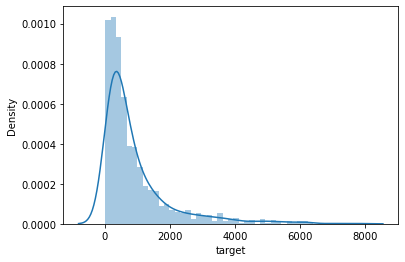

In [6]:
#number of hits, target값의 type을 string에서 float로 변환하겠습니다.
df['target'] = df['target'].apply(lambda x : x.replace(',', ''))
df['number of hits'] = df['number of hits'].apply(lambda x : x.replace(',', ''))

df[['target','number of hits']] = df[['target','number of hits']].astype(np.float)

#Target 데이터의 왜곡을 확인하기 위해 시각화하겠습니다.
import seaborn as sns

sns.distplot(df['target'])



<AxesSubplot:xlabel='target', ylabel='Density'>

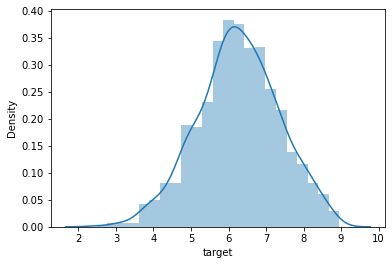

In [7]:
# 왜곡이 있으므로 왜곡을 줄이기 위해 로그변환하도록 하겠습니다.
df['target'] = np.log1p(df['target'])
sns.distplot(df['target'])

In [8]:
# Null값이 있는 rate 변수에 대해 평균값을 적용
df.fillna(df.mean(), inplace = True)

In [9]:
# 각 문자열 변수들의 값을 보고 너무 세분화된 문자열은 삭제하도록 하겠습니다.
df['food category'].value_counts() 

한식      599
카페      259
양식       46
일식       39
중식       20
주점       20
세계음식     13
뷔페        4
Name: food category, dtype: int64

In [10]:
df['detaild food category'].value_counts() #삭제

카페 / 디저트            223
탕 / 찌개 / 전골         124
국수 / 면 요리           114
한정식 / 백반 / 정통 한식     96
고기 요리                88
해산물 요리               88
닭 / 오리 요리            58
베이커리                 36
기타 한식                28
브런치 / 버거 / 샌드위치      18
이탈리안                 16
정통 중식 / 일반 중식        15
라멘 / 소바 / 우동          8
일반 주점                 8
돈부리 / 일본 카레 / 벤토      8
회 / 스시                7
기타 양식                 6
기타 일식                 5
전통 주점 / 포차            5
치킨 / 호프 / 펍           5
태국 음식                 4
뷔페                    4
까스 요리                 4
정통 일식 / 일반 일식         4
퓨전 한식                 3
스테이크 / 바베큐            3
세계음식 기타               3
기타 중식                 3
이자카야 / 오뎅 / 꼬치        3
퓨전 양식                 2
딤섬 / 만두               2
인도 음식                 2
칵테일 / 와인              2
베트남 음식                1
다국적 아시아 음식            1
다국적 퓨전                1
남미 음식                 1
프랑스 음식                1
Name: detaild food category, dtype: int64

In [11]:
df['parking'].value_counts()

무료주차가능    471
주차공간없음    339
유료주차가능     67
발렛         25
Name: parking, dtype: int64

In [12]:
df['open hours'].value_counts() #삭제

11:00 - 21:00                             51
11:00 - 22:00                             47
00:00 - 24:00                             32
10:00 - 22:00                             32
09:00 - 21:00                             27
                                          ..
월-금: 08:00 - 20:00, 토-일: 07:00 - 20:00     1
10:30 - 01:00                              1
월-금: 11:00 - 20:00, 토-일: 10:30 - 20:30     1
10:00 - 19:50                              1
월-금: 12:00 - 22:00, 토-일: 12:00 - 21:00     1
Name: open hours, Length: 331, dtype: int64

In [13]:
df['main dish'].value_counts() #삭제

카페                 174
전통순대 / 순대국밥 전문점     39
베이커리                33
횟집                  31
닭갈비 전문점             26
                  ... 
찹쌀떡 전문점              1
야끼니꾸 전문점             1
기타 국수 전문점            1
콩국수 전문점              1
멕시칸 음식               1
Name: main dish, Length: 176, dtype: int64

In [14]:
df['price per person'].value_counts()

만원 미만      571
만원-2만원     276
2만원-3만원     86
3만원-4만원     33
4만원 이상      26
Name: price per person, dtype: int64

In [15]:
#문자형 피처는 pd.get_dummies()를 이용해 원핫인코딩으로 변환
#get_dummies()는 Null값을 자동으로 None 칼럼으로 대체해주기 때문에 별도의 작업 필요하지 않습니다.

#이때 소분류가 너무 많은 name, detailed food category, open hours, main dish, date 등 삭제하겠습니다.
df.drop(['name','detaild food category','open hours','main dish','date'],axis=1,inplace=True)
df_ohe = pd.get_dummies(df)

df_ohe.head()

,latitude,longitude,rate,number of reviews,number of hits,target,price per person_2만원-3만원,price per person_3만원-4만원,price per person_4만원 이상,price per person_만원 미만,...,food category_양식,food category_일식,food category_주점,food category_중식,food category_카페,food category_한식,parking_무료주차가능,parking_발렛,parking_유료주차가능,parking_주차공간없음
0,37.497926,126.998425,3.8,30,8904.0,4.941642,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0
1,37.525495,127.052763,3.9,185,71798.0,7.528332,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0
2,37.525478,127.032324,3.7,115,101644.0,7.967627,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
3,37.524050,127.049703,4.3,49,54606.0,7.280008,0,1,0,0,...,0,0,0,0,0,1,0,1,0,0
4,37.491123,127.011033,3.9,55,63023.0,7.146772,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0


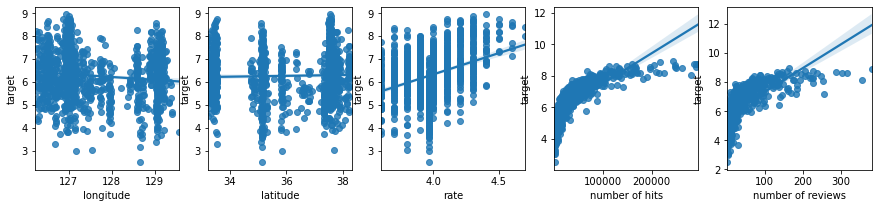

In [16]:
# 주요 Numeric 변수들(longitude, latitude, rate, number of hits, nubmer of reviews)와 target변수 간 관계를 시각화하겠습니다.

# 회귀선을 함께 그려주는 시본 regplot()을 통해 각 피처와 레이블의 관계를 시각화
fig, axs = plt.subplots(figsize=(15,3), ncols=5, nrows=1)
lm_features = ['longitude','latitude','rate','number of hits','number of reviews']
for i, feature in enumerate(lm_features):
    col = i%5
    sns.regplot(x=feature, y = 'target', data=df_ohe, ax=axs[col])

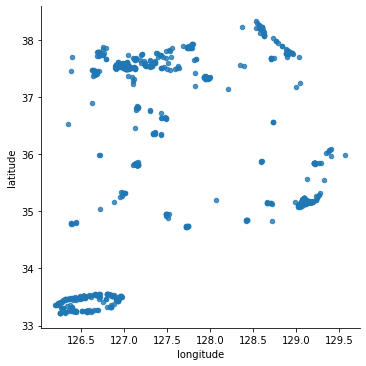

In [17]:
'''rate, number of hits, number of reviews는 target에 중요한 특성들로 보이지만 위도와 경도는 그렇지 못한걸로 보입니다.
하지만 식당의 위치 또한 매우 중요한 요소란 점을 감안했을 때 위도와 경도의 영향을 무시할 수 없음
또한 식당은 상권을 이루고 있는 경우가 많기 때문에 위도와 경도가 유사한 지역끼리 하나의 상권으로 묶어 이를 파악하는 작업이 필요한데
이를 위해서 "k 평균 군집화" 머신러닝 기법 사용하겠습니다.

k평균 군집화는 비슷한 데이터끼리 같은 부류로 묶어주는 머신러닝 기법입니다.
'''

#먼저 위도와 경도에 따른 식당의 위치 시각화
sns.lmplot('longitude','latitude',data=df_ohe, fit_reg = False, scatter_kws={"s":20})

#시각화된 위치는 우리나라의 모습을 그대로 보여주고 있습니다.

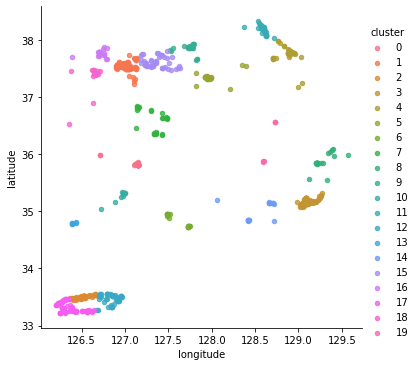

In [18]:
#20개의 지역으로 군집화
from sklearn.cluster import KMeans
data_points = df_ohe[['longitude','latitude']].values
kmeans = KMeans(n_clusters=20).fit(data_points)

#데이터 저장
df_ohe['cluster'] = kmeans.labels_

#k 평균 군집 시각화
sns.lmplot('longitude', 'latitude', data=df_ohe, fit_reg=False, scatter_kws = {'s':20}, hue="cluster")

In [19]:
#군집은 대한민국 상에서 위치를 나타내는 값으로 이 역시 원핫 인코딩으로 더미변수화 하겠습니다.
df_ohe = pd.get_dummies(df_ohe, columns=['cluster'])

#cluster변수가 새로 생겼으므로 latitude 변수와 longitude변수는 삭제
df_ohe.drop(['latitude','longitude'],axis=1,inplace=True)

In [20]:
df_ohe.head()

,rate,number of reviews,number of hits,target,price per person_2만원-3만원,price per person_3만원-4만원,price per person_4만원 이상,price per person_만원 미만,price per person_만원-2만원,food category_뷔페,...,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17,cluster_18,cluster_19
0,3.8,30,8904.0,4.941642,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3.9,185,71798.0,7.528332,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3.7,115,101644.0,7.967627,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,4.3,49,54606.0,7.280008,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3.9,55,63023.0,7.146772,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
df_ohe.columns #현재 칼럼정보들입니다.

Index(['rate', 'number of reviews', 'number of hits', 'target',
       'price per person_2만원-3만원', 'price per person_3만원-4만원',
       'price per person_4만원 이상', 'price per person_만원 미만',
       'price per person_만원-2만원', 'food category_뷔페', 'food category_세계음식',
       'food category_양식', 'food category_일식', 'food category_주점',
       'food category_중식', 'food category_카페', 'food category_한식',
       'parking_무료주차가능', 'parking_발렛', 'parking_유료주차가능', 'parking_주차공간없음',
       'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4',
       'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8', 'cluster_9',
       'cluster_10', 'cluster_11', 'cluster_12', 'cluster_13', 'cluster_14',
       'cluster_15', 'cluster_16', 'cluster_17', 'cluster_18', 'cluster_19'],
      dtype='object')

In [22]:
'''3.데이터 분할
데이터를 학습을 위한 데이터와 테스트를 위한 데이터로 나누겠습니다.
'''

from sklearn.model_selection import train_test_split

y_target = df_ohe['target']
X_features = df_ohe.drop('target',axis=1,inplace=False)

# 테스트 사이즈 = 0.2로 학습용 데이터와 테스트용 데이터를 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2)

In [23]:
''' 4.모델 평가지표 설정'''

#모델 평가는 RMSE이용하겠습니다. 이때 target값이 log변환이 되어있기 때문에 사실상 RSMLE를 이용하는 것과 같습니다.

from sklearn.metrics import mean_squared_error

def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    rmse = np.mean(mse)
    print(model.__class__.__name__, '로그 변환된 RMSE :', np.round(rmse,3))
    return rmse

def get_rmses(models):
    rmses = []
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    
    return rmses

#모델 학습, 예측 ,평가를 실행하겠습니다.
#모델은 선형회귀, 릿지, 라쏘 등 3개를 이용하겠습니다.
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# RMSE 결과는 0.4~0.5 사이로 나왔습니다.

LinearRegression 로그 변환된 RMSE : 0.427
Ridge 로그 변환된 RMSE : 0.421
Lasso 로그 변환된 RMSE : 0.456


[0.42706262985939347, 0.4214727411609195, 0.4564527223043373]

'\n결과를 보면 선형회귀와 릿지모델은 유사한 결과를 도출하는 반면 라쏘모델은 다른 결과를 도출합니다.\n이때 선형회귀와 릿지모델의 정확성이 더 높게 나왔으므로 두 모델의 회귀계수의 신뢰성이 더 높습니다.\n선형회귀모델과 릿지모델에 따르면 식당이 위치한 지역(cluster)와 주차유무, 평점이 target값에 긍정적인 영향을 미칩니다'

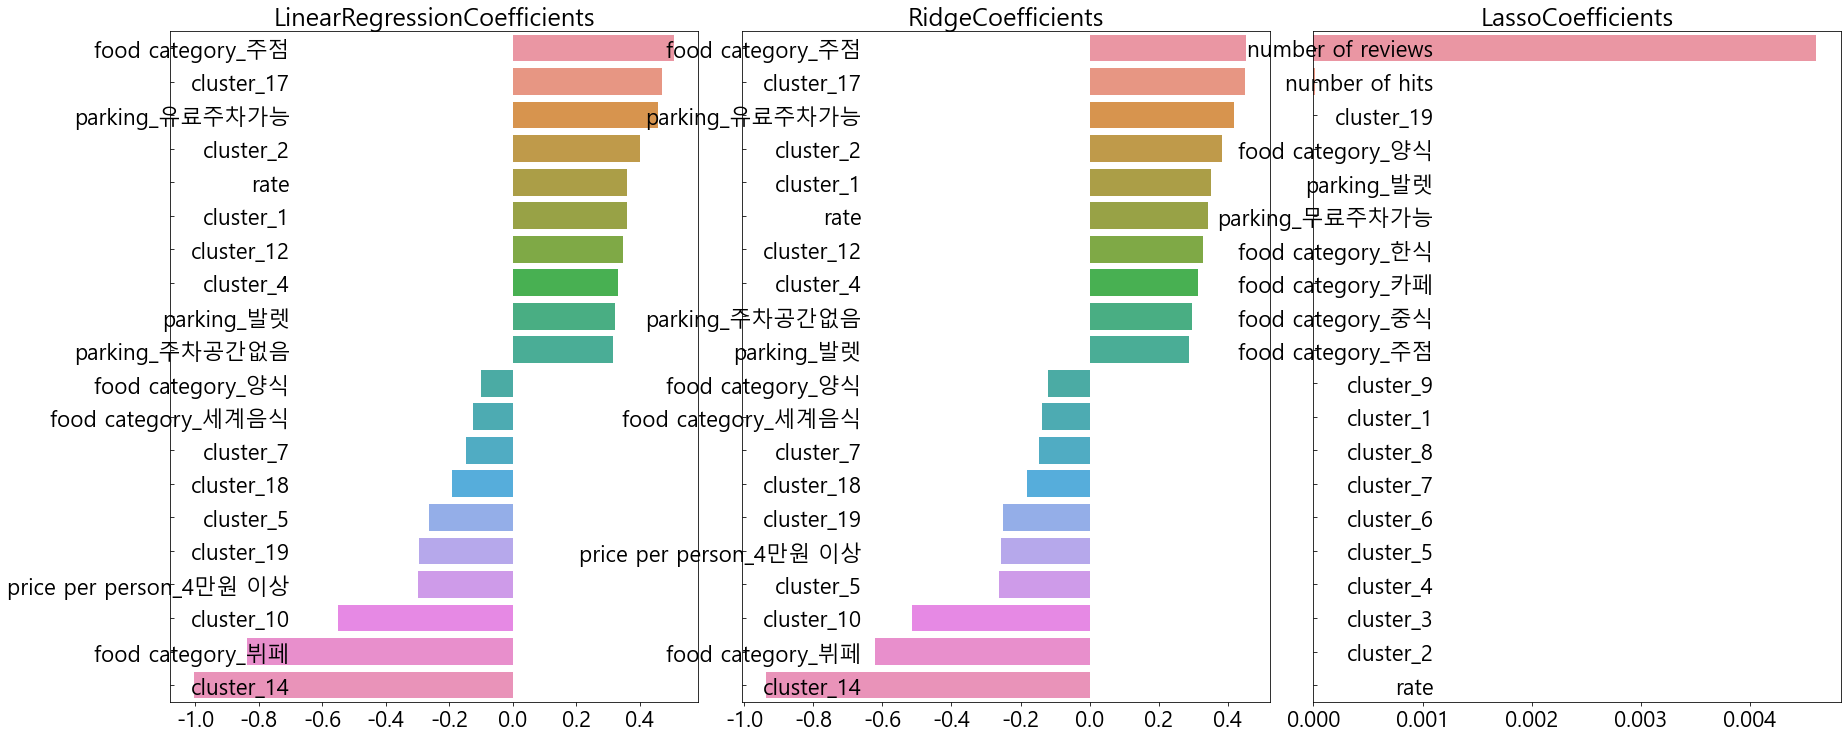

In [24]:
#피처별 회귀계수 시각화(상위,하위 10개)하겠습니다. 

def get_top_bottom_coef(model, n=10): #상위,하위 10개 추출하는 함수
    coef = pd.Series(model.coef_, index=X_features.columns)
    
    #상위,하위 10개 회귀계수 추출해 반환
    coef_high = coef.sort_values(ascending=False).head(n)
    coef_low = coef.sort_values(ascending=False).tail(n)
    return coef_high, coef_low

def visualize_coefficient(models): #시각화
    #그래프에서 한글사용 세팅
    plt.rcParams['font.family'] = 'Malgun Gothic' #맑은 고딕
    plt.rcParams['font.size'] = 12
    plt.rcParams['axes.unicode_minus'] = False
    
    #3개모델의 시각화를 위해 3개의 칼럼을 가지는 subplot생성
    fig, axs = plt.subplots(figsize=(24,10), nrows=1, ncols=3)
    fig.tight_layout()
    
    for i_num, model in enumerate(models):
        coef_high, coef_low = get_top_bottom_coef(model, n=10)
        coef_concat = pd.concat([coef_high, coef_low]) #concat으로 시리즈 결합
        #ax subplot에 barchar로 표현, 한 화면에 표현하기 위한 tick label 위치와 font 크기 조정
        axs[i_num].set_title(model.__class__.__name__ + 'Coefficients', size=25)
        axs[i_num].tick_params(axis='y', direction='in',pad=-120)
        
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[i_num])
        
#모델 회귀계수 시각화
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

'''
결과를 보면 선형회귀와 릿지모델은 유사한 결과를 도출하는 반면 라쏘모델은 다른 결과를 도출합니다.
이때 선형회귀와 릿지모델의 정확성이 더 높게 나왔으므로 두 모델의 회귀계수의 신뢰성이 더 높습니다.
선형회귀모델과 릿지모델에 따르면 식당이 위치한 지역(cluster)와 주차유무, 평점이 target값에 긍정적인 영향을 미칩니다'''


In [25]:
#릿지와 라쏘모델에 하이퍼 파라미터 튜닝을 적용하겠습니다.
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params, 
                              scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_features, y_target)
    rmse = np.sqrt(-1* grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                        np.round(rmse, 4), grid_model.best_params_))
    return grid_model.best_estimator_

ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_rige = print_best_params(ridge_reg, ridge_params)
best_lasso = print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.6813, 최적 alpha:{'alpha': 5}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.6863, 최적 alpha:{'alpha': 0.001}


LinearRegression 로그 변환된 RMSE : 0.427
Ridge 로그 변환된 RMSE : 0.411
Lasso 로그 변환된 RMSE : 0.421


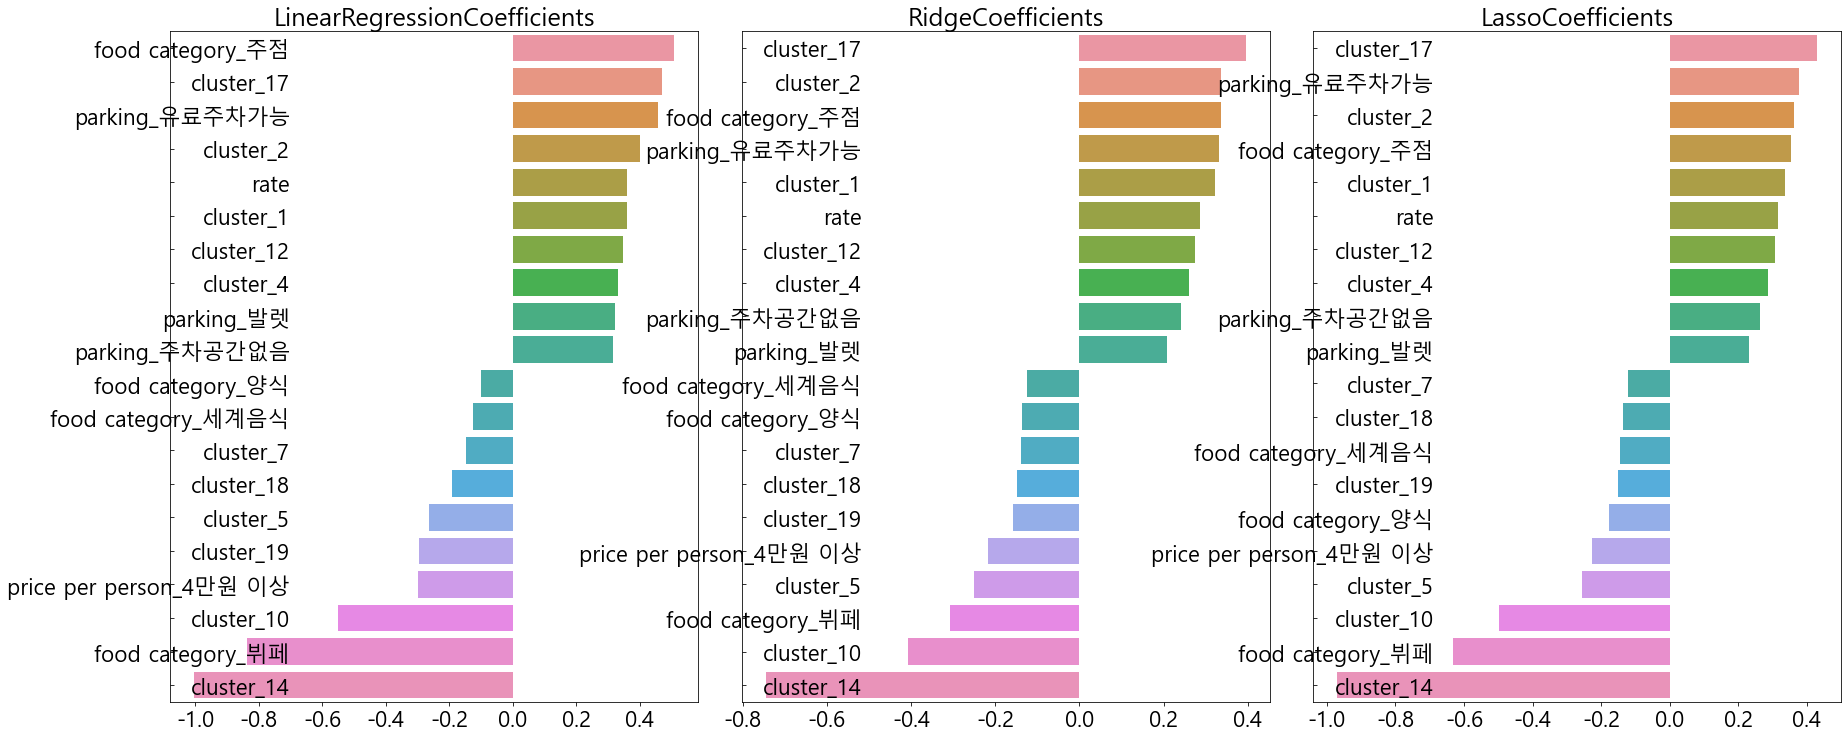

In [26]:
# 앞의 최적화 alpha값으로 학습데이터로 학습, 테스트 데이터로 예측 및 평가를 다시 수행하겠습니다.
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=5)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화 
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

#튜닝 후 라쏘모델의 예측성능이 향상됨, 라쏘 모델의 결과도 릿지, 선형회귀와 결과가 유사해졌습니다.

In [27]:
# 이상치 처리를 통해 모델을 튜닝하겠습니다.
# 사이파이 stats 모듈의 skew() 함수를 이용, 칼럼의 왜곡도 확인, 일반적으로 1 이상일 때 왜곡도가 높다고 판단, 1 이상인 데이터 피처에 대해 로그 변환을 시행하겠습니다.

from scipy.stats import skew

# # object가 아닌 숫자형 피쳐의 컬럼 index 객체 추출.
features_index = df.dtypes[df.dtypes != 'object'].index
# house_df에 컬럼 index를 [ ]로 입력하면 해당하는 컬럼 데이터 셋 반환. apply lambda로 skew( )호출 
skew_features = df[features_index].apply(lambda x : skew(x))
# skew 정도가 1 이상인 컬럼들만 추출. 
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

number of reviews    3.358797
number of hits       2.916513
dtype: float64


In [28]:
# 추출된 피처를 로그 변환하겠습니다.
df[skew_features_top.index] =  np.log1p(df[skew_features_top.index])

In [29]:
# Skew가 높은 피처들을 로그 변환 했으므로 다시 원-핫 인코딩 적용 및 피처/타겟 데이터 셋을 생성하겠습니다.
df_ohe = pd.get_dummies(df)

data_points = df_ohe[['longitude','latitude']].values
kmeans = KMeans(n_clusters=20).fit(data_points)

#데이터 저장
df_ohe['cluster'] = kmeans.labels_

#군집은 대한민국 상에서 위치를 나타내는 값으로 이 역시 원핫 인코딩으로 더미변수화하겠습니다.
df_ohe = pd.get_dummies(df_ohe, columns=['cluster'])

#cluster변수가 새로 생겼으므로 latitude 변수와 longitude변수는 삭제하겠습니다.
df_ohe.drop(['latitude','longitude'],axis=1,inplace=True)

y_target = df_ohe['target']
X_features = df_ohe.drop('target',axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# 피처들을 로그 변환 후 다시 최적 하이퍼 파라미터와 RMSE 출력하겠습니다.
ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_ridge = print_best_params(ridge_reg, ridge_params)
best_lasso = print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.3258, 최적 alpha:{'alpha': 1}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.3264, 최적 alpha:{'alpha': 0.001}


LinearRegression 로그 변환된 RMSE : 0.099
Ridge 로그 변환된 RMSE : 0.099
Lasso 로그 변환된 RMSE : 0.099


'\n각 모델들의 RMSE가 눈에 띄게 하락한 것을 볼 수 있습니다.\n또한 모델들이 산출한 결과가 유사해졌고, 합리적으로 생각되어지는 결과들이 도출되었습니다.\n'

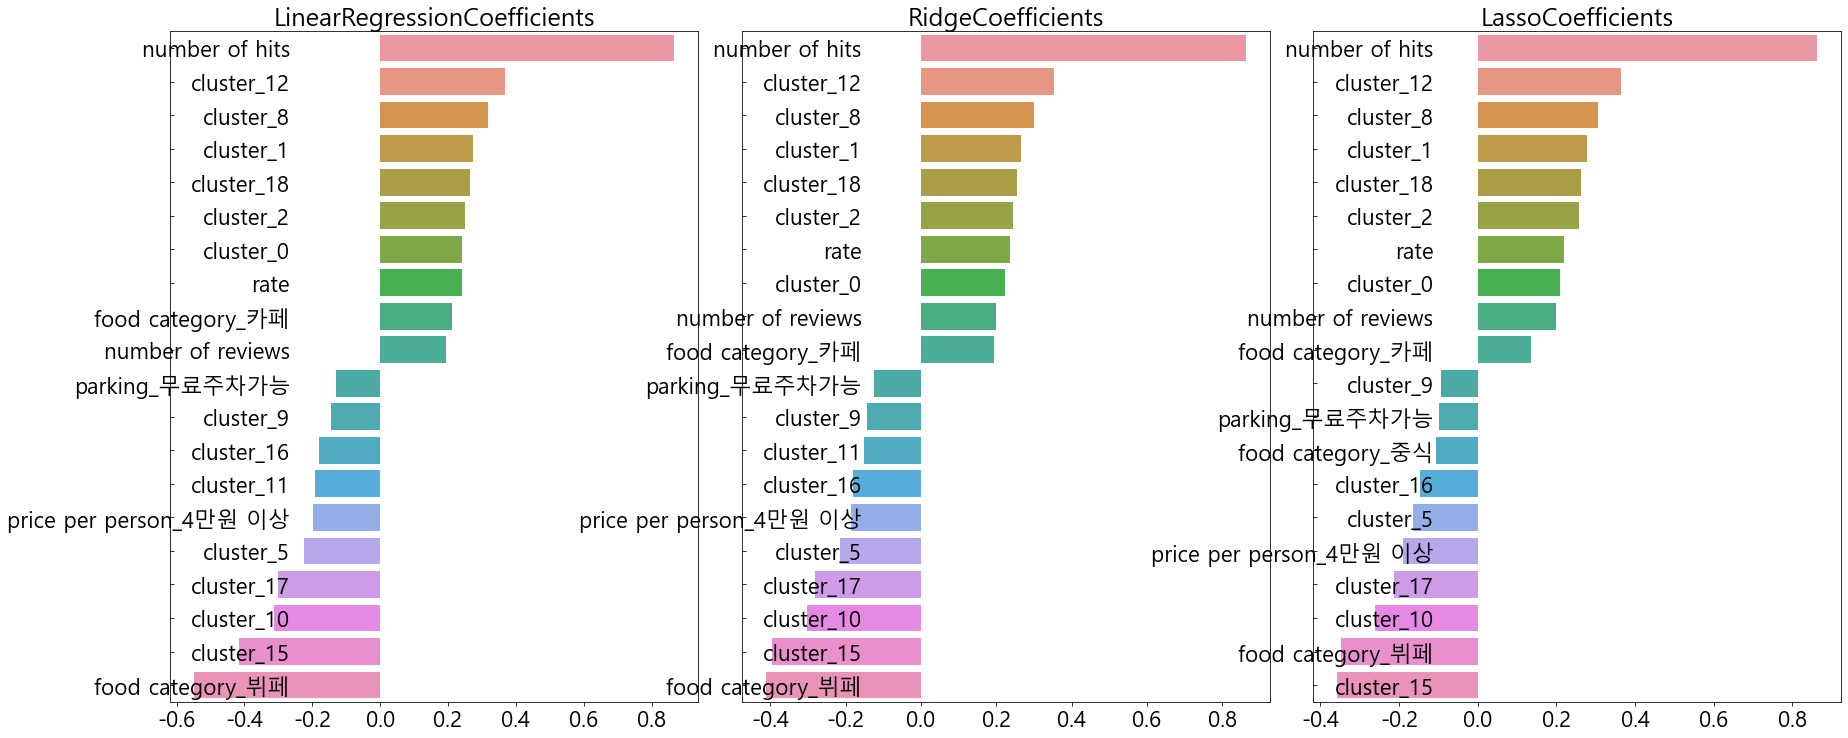

In [30]:
# 앞의 최적화 alpha값으로 학습데이터로 학습, 테스트 데이터로 예측 및 평가 수행하겠습니다.
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=1)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화 
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

'''
각 모델들의 RMSE가 눈에 띄게 하락한 것을 볼 수 있습니다.
또한 모델들이 산출한 결과가 유사해졌고, 합리적으로 생각되어지는 결과들이 도출되었습니다.
'''

'\n밑에 보이는 바와 같이 예측값(prediction value)와 실제값(real value)가 45도선을 기준으로 높은 정확성을 보이고 있습니다.\n이로써 식당 상권 데이터와 머신러닝 기법을 이용한 식당 수요 예측 모델이 완성되었습니다.\n읽어주셔서 감사합니다.\n'

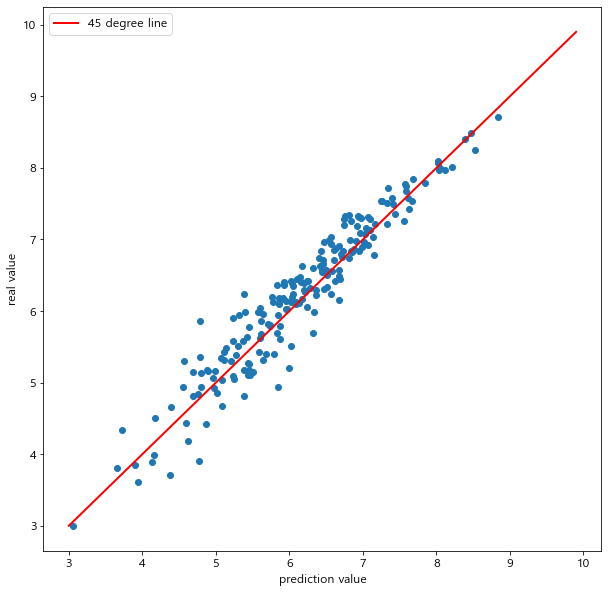

In [31]:
#정확도가 가장 높았던 Lasso 모델을 이용해 예측값과 실제값이 어느정도로 유사한지 시각화해보겠습니다.
y_predict = lasso_reg.predict(X_test)
y_predict = pd.Series(y_predict)

line_45 = np.arange(3,10,0.1)
plt.figure(figsize=(10,10))
plt.scatter(y_predict, y_test)
plt.xlabel('prediction value')
plt.ylabel('real value')
plt.plot(line_45, line_45, label='45 degree line', linewidth=2, color='r')
plt.legend(loc='best')

'''
밑에 보이는 바와 같이 예측값(prediction value)와 실제값(real value)가 45도선을 기준으로 높은 정확성을 보이고 있습니다.
이로써 식당 상권 데이터와 머신러닝 기법을 이용한 식당 수요 예측 모델이 완성되었습니다.
읽어주셔서 감사합니다.
'''